## Comment Algorithm Explained

Notebook working through an example of how Reddit sorts their comments. 

### Confidence Sort Using Wilson's Score Interval - For Comment Ranking

**Goal:** Rank the best comments highest regardless of their submission time (time was originally used in the main Reddit page algorithm which is different than the comment sorting found here) 

The confidence sort treats the vote count as a statistical sampling of a hypothetical full vote by everyone. You can think about this way: 
- "Given the ratings that I currently have, there is a 80% chance (based on your chosen confidence score) that the 'real' fraction of positive ratings is **at least** what?

The algorithm then uses the **lower bound** of the Wilson score to find this fraction, using the formula below. 

![Wilson Formula](../notebooks/images/wilson-formula.png)

Essentially the confidence sort is giving the comment a provisional ranking that it is 80% (based on your confidence score) sure that it will get to. If a comment has 1 upvote and zero downvotes, although it has a 100% upvote rate since there is not much data the algorithm will keep it near the bottom. But if it has 10 upvotes and 1 downvote then the system will have enough confidence to place it above something with 40 upvotes and 20 downvotes - with the logic being that by the time this comment has gotten 40 upvotes it will have less than 20 downvotes. The algorithm also has the capability to offset when it is wrong (20% of the time according to our confidence score) since it will push the comment with less data to the top allowing for the chance to collect more data. 


Essentially the Wilson Score uses statistics to try and predict the "true" expected ratio of upvotes to total votes based on the current sample (current number of upvotes and downvotes).

In [1]:
from math import sqrt
import pandas as pd
from scipy.stats import norm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def confidence(ups, downs, confidence_score=0.80):
    #measure the total number of ratings
    n = ups + downs
    #what to do when there are no ratings
    if n == 0:
        return 0
    # finding the (1- confidence / 2) quantile of the standard normal distribution
    z = norm.ppf(1 - ((1 - confidence_score) / 2))
    #find the observed fraction of positive ratings
    p = ups / n
    #use Wilsons score interval to find the lower bound, essentially trying to answer
    # Given the ratings I have, there is a 80% chance (based on confidence score) that the
    # "real" fraction of positive ratings is at least what?
    #     we want the lower bound therefore only calculating that portion of formula
    #Calculate the left side of formula
    left_side = p + 1/(2*n)*z*z
    #Calculate the right side of formula
    right_side = z*sqrt(p*(1-p)/n + z*z/(4*n*n))
    #Calculate the bottom side of formula
    under = 1+1/n*z*z
    #return lower bound of score
    return (left_side - right_side) / under

Consider a scenario where we have a post with 20 upvotes and 5 downvotes. 

We can see that we get a Wilson score of 0.68. This means that we are predicting that the lowest possible proportion of upvotes to total votes with an 80% degree of confidence is 0.68.

In [ ]:
#get score for scenario
score = confidence(14, 2, confidence_score=0.8)
score

Consider that this same post eventually gets 50 total votes.

Then according to the Wilson score the predicted lowest possible amount of downvotes, with an 80% degree of confidence, that this post could have gotten would be around 15.97 downvotes.

In [ ]:
#lets say that eventually this scenario gets 50 votes
total_votes = 50
#now calculate the predicted lowest number of downvotes
downvotes = total_votes - (total_votes * score)
downvotes

#### How many resources could we expect to get validated?

Set initial requirements to test

In [ ]:
#minimal number of votes needed
num_votes = 20
##set threshold percentage of upvotes/total votes
threshold = 0.70

In [ ]:
#keep track of scores
scores_eighty, scores_ninety = [], []
#go through possible combinations of upvotes to downvotes
for upvotes in range(num_votes + 1):
    #get number of downvotes
    downvotes = num_votes - upvotes
    #get the score for current scenario with 80% confidence
    scores_eighty.append(confidence(upvotes, downvotes, 0.80))
    #get the score for current scenario with 90% confidence
    scores_ninety.append(confidence(upvotes, downvotes, 0.90))

In [ ]:
#build figure image
fig = plt.subplots(figsize=(10, 5))
#plot 80% confidence scores
ax = sns.lineplot(x=range(num_votes+1), y=scores_eighty, label='80% Confidence', linestyle='dotted', marker='*', markersize=15)
#plot 90% confidence scores
sns.lineplot(x=range(num_votes+1), y=scores_ninety, label='90% Confidence', linestyle='dotted', marker='*', markersize=15)
#set the x and y ticks for the plot
ax.set_xticks(range(num_votes+1))
ax.set_yticks(np.linspace(0, 1, 11))
#set title and labels
ax.set(title='Wilson Score For Number of Upvotes Out Of 20', xlabel='Number of Upvotes', ylabel='Wilson Score')
#plot horizontal line at proportion 0.7
ax.axhline(threshold, ls='--', color='red')
#show the legend
ax.legend()
#show the plot
plt.show()

In [ ]:
#function that simulates vote scenarios meeting validation threshold
def count_validated(vote_scenarios):
    #percentage validated scenarios 
    percent_eighty, percent_ninety = [], []
    #loop through different scenarios
    for scenario in vote_scenarios:
        #keep track of validated resources
        validated_eighty, validated_ninety = 0, 0
        #go through all possible combinations of upvotes to downvotes
        for upvotes in range(scenario + 1):
            #get the number of downvotes
            downvotes = scenario - upvotes
            #get the current 80% confidence score
            curr_score_eighty = confidence(upvotes, downvotes, 0.80)
            #get the current 90% confidence score
            curr_score_ninety = confidence(upvotes, downvotes, 0.90)
            #check to see if we passed the threshold
            if curr_score_eighty >= threshold:
                #increment number of validated resources
                validated_eighty += 1
            if curr_score_ninety >= threshold:
                #increment number of validated resources
                validated_ninety += 1
        #append percentage of validated scenarios
        percent_eighty.append(round(validated_eighty / scenario, 2))
        percent_ninety.append(round(validated_ninety / scenario, 2))
    return percent_eighty, percent_ninety

#different scenarios of number of needed votes
vote_scenarios = list(range(20, 55, 5))
#get the percentage of resources that were valiated
percent_eighty, percent_ninety = count_validated(vote_scenarios)

In [ ]:
#make a dataframe
df = pd.DataFrame({
    "total_votes": vote_scenarios,
    "80%": percent_eighty,
    "90%": percent_ninety
})

#convert dataframe to long format
dfm = pd.melt(df, id_vars="total_votes", var_name="confidence", value_name="%_validated")
#plot the results
g = sns.catplot(x='total_votes', y='%_validated', hue='confidence', data=dfm, kind='bar')
#set title
g.set(title=f"% Scenarios Meeting {threshold} Validation Threshold")

In [ ]:
#different scenarios of number of needed votes
vote_scenarios = list(range(55, 90, 5))
#get the percentage of resources that were valiated
percent_eighty, percent_ninety = count_validated(vote_scenarios)

#make a dataframe
df = pd.DataFrame({
    "total_votes": vote_scenarios,
    "80%": percent_eighty,
    "90%": percent_ninety
})

#convert dataframe to long format
dfm = pd.melt(df, id_vars="total_votes", var_name="confidence", value_name="%_validated")
#plot the results
g = sns.catplot(x='total_votes', y='%_validated', hue='confidence', data=dfm, kind='bar')
#set title
g.set(title=f"% Scenarios Meeting {threshold} Validation Threshold")

Inherent "minimum number of votes" requirement built in through the formula. As we can see below even if we have a scenario where a post has 5 upvotes / 0 downvotes, the wilson score doesn't pass the validation threshold because it it does not have enough information to recommend a higher score.

In [ ]:
print(f"Score for 5 upvotes to 0 downvotes at 90% confidence: {round(confidence(5, 0, 0.9), 3)}")

In [ ]:
#different scenarios of number of needed votes
vote_scenarios = list(range(1, 11, 1))
#get the percentage of resources that were valiated
percent_eighty, percent_ninety = count_validated(vote_scenarios)

#make a dataframe
df = pd.DataFrame({
    "total_votes": vote_scenarios,
    "80%": percent_eighty,
    "90%": percent_ninety
})

#convert dataframe to long format
dfm = pd.melt(df, id_vars="total_votes", var_name="confidence", value_name="%_validated")
#plot the results
g = sns.catplot(x='total_votes', y='%_validated', hue='confidence', data=dfm, kind='bar')
#set title
g.set(title=f"% Scenarios Meeting {threshold} Validation Threshold")

### Distribution of Scores

In [ ]:
#build data dictionary
data_dic = {}

#keep track of the row index
row_index = 0
#loop through scenarios for total votes
for total_votes in range(1, 31):
    for upvotes in range(1, total_votes + 1):
        #get the current upvotes and downvotes
        downvotes = total_votes - upvotes
        #get the confidence score for different scenarios at different confidence levels
        eighty_conf = confidence(upvotes, downvotes, confidence_score=0.8)
        ninety_conf = confidence(upvotes, downvotes, confidence_score=0.9)
        #build the current row
        data_dic[row_index] = [total_votes, upvotes, downvotes, eighty_conf, ninety_conf]
        #increment the index
        row_index += 1

#build dataframe from data
df = pd.DataFrame.from_dict(data_dic, orient='index', 
        columns=["total_votes", "upvotes", "downvotes", "80%_score", "90%_score"])

In [ ]:
sns.scatterplot(data=df, x="total_votes", y="80%_score")

In [ ]:
sns.scatterplot(data=df, x="total_votes", y="90%_score")

### Set Requirements / Wishlist

- threshold: (0 - 1) the minimum accepted ratio of upvotes / total votes we would accept to be considered validated
- confidence: (0 - 1) the certainty percentage or how confident we can say that the resource will achieve this threshold
- next votes: the next x amount of scenarios to consider

In [14]:
#minimum accepted ratio of upvotes to total votes
threshold = 0.70
#how confident we aim to be
curr_confidence = 0.90
#the next x amount of voting scenarios to consider
next_votes = 20
#minimum accepted probability that the resources will stay validated
probability = 0.70

In [15]:
#keep track of data
data_dic = {}

#minimum number total votes needed to pass probability threshold
min_votes = None
#initial scenarios to consider
for total_votes in range(8, 100):
    #keep track of outcomes
    passed = 0
    #keep track of added trials
    trials = 0
    #now consider the next x amount of votes
    for added_votes in range(1, next_votes + 1):
        for curr_upvotes in range(added_votes + 1):
            #increment trials
            trials += 1
            if confidence(total_votes + curr_upvotes, added_votes - curr_upvotes, confidence_score=curr_confidence) >= threshold:
                # print(f"Original: {total_votes}")
                # print(f"Upvotes: {total_votes + curr_upvotes}, Downvotes: {added_votes - curr_upvotes}")
                passed += 1
    #calculate the current probability
    curr_probability = passed / trials
    #keep track minimum total votes need to pass probability threshold
    if curr_probability >= probability and min_votes is None:
        #update min votes to keep track of first instance where we pass probability threshold
        min_votes = total_votes
    #save the current probability
    data_dic[total_votes] = curr_probability

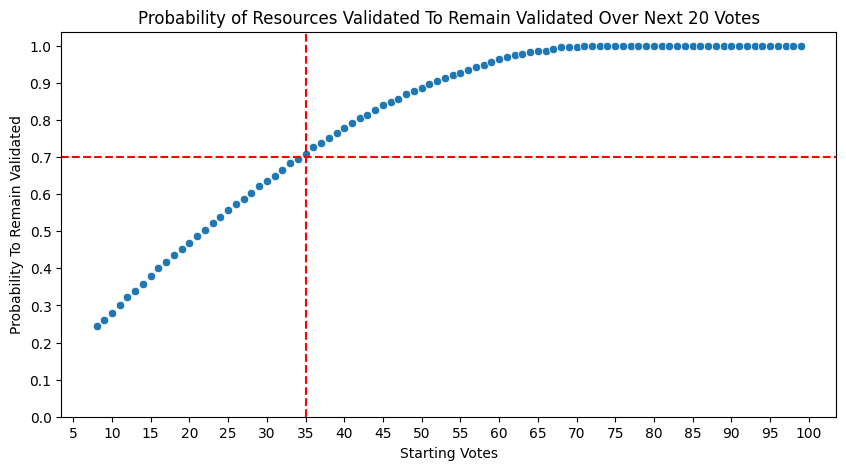

In [16]:
#build figure image
fig = plt.subplots(figsize=(10, 5))
#build a scatter plot for probability to remain validated
ax = sns.scatterplot(x=list(data_dic.keys()), y=list(data_dic.values()))
#set the x and y ticks for the plot
ax.set_xticks(np.linspace(5, 100, 20))
ax.set_yticks(np.linspace(0, 1, 11))
#set title and labels
ax.set(title=f'Probability of Resources Validated To Remain Validated Over Next {next_votes} Votes',
       xlabel='Starting Votes', 
       ylabel='Probability To Remain Validated')
#plot horizontal line
ax.axhline(probability, ls='--', color='red')
#plot vertical line
ax.axvline(min_votes, ls='--', color='red')
#show the plot
plt.show()